# Data:
- Geometry (area, curvature)
    - $A$, $Ms^{f}$, $<H>$.
- Topology (corner)
    - $C$, $C-<Cnn>$
- Migration
    - sign, distance
    - Energy gradient: grain & connected face
- Energy
- Crystallography
  - misorientation angle from sigma3.
  - weighted average distance from coherent twin. 
    
## Directions:
  - Prediction & Correlation.
  - In-plane evolution (area, curvature) & Out-of-plane migration
  
## Possible assumptions: 
- Faces move in a direction consistent with the energy gradient within the grain pair. 
- Faces move in a direction / with a magnitude consistent with face curvature
- Faces that are increasing in area move along with the energy gradient.
- Faces with large $C$, $Ms^{f}$, $|C - <Cnn>|_{an4}$ move long distances.
- Face migration distances are related to crystallography.
- Geometry   vs.   Geometry
- Gemoetry   vs.   Topology
- Gemoetry/Topology   vs.   Migration
- energy   vs.   mig_dist


In [51]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
# from matplotlib.pylab import rcParams

mig = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190408_features_mig.txt')
mig_sign = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190408_features_mig_signs.txt')
energy_grad = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190421_features_energygrad.txt')
geo_topo = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190421_features_geo_topo.txt')
other = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190408_features_otherinfo.txt')

mig.columns = mig.columns.str.strip()
mig_sign.columns = mig_sign.columns.str.strip()
energy_grad.columns = energy_grad.columns.str.strip()
geo_topo.columns = geo_topo.columns.str.strip()
other.columns = other.columns.str.strip()

In [39]:
from scipy.io import loadmat
# mat = scipy.io.loadmat('/Volumes/XIAOTING/Ni/working/Grain Tracking/tmp_190416.mat')
# dists_f_g_an4 = mat['dists_f_g_an4']
# dists_f_g_an5 = mat['dists_f_g_an5']

# eps_motion = 0.001;
# move_left = np.zeros([dists_f_g_an4.shape[0], 1]);
# for i in range(dists_f_g_an4.shape[0]):
#     if dists_f_g_an4[i, 0] < dists_f_g_an5[i, 0] - eps_motion:
#         move_left[i] = -1;
#     elif dists_f_g_an4[i, 0]  > dists_f_g_an5[i, 0]  + eps_motion:
#         move_left[i] = 1;
#     else:
#         move_left[i] = 0;

data = loadmat('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190420_dist_left_from_an4normproj.mat')
dist_left = data['dist_left']

eps = 0.5
mask_pos = dist_left > eps
mask_neg = dist_left < -eps

move_left = np.zeros(dist_left.shape)
move_left[mask_pos] = 1
move_left[mask_neg] = -1



energy_grad.iloc[:, 0] = move_left
print np.sum(move_left == 0)

842


### EDA
- If using dihedral angles, then need to filter out nans

In [52]:
geo_topo = geo_topo.astype(float)
mask_nonan = ~(np.any(np.isnan(geo_topo), axis=1))
geo_topo = geo_topo[mask_nonan]
energy_grad = energy_grad[mask_nonan]
other = other[mask_nonan]

geo_topo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6952 entries, 0 to 7003
Data columns (total 22 columns):
da_len_w_an4_l       6952 non-null float64
da_len_w_an4_r       6952 non-null float64
da_len_w_an4_opp     6952 non-null float64
da_num_w_an4_l       6952 non-null float64
da_num_w_an4_r       6952 non-null float64
da_num_w_an4_opp     6952 non-null float64
A_an4                6952 non-null float64
fMs_an4              6952 non-null float64
avg_FabsavgH_an4     6952 non-null float64
C_an4                6952 non-null float64
CnnC_an4             6952 non-null float64
da_len_w_diff_l      6952 non-null float64
da_len_w_diff_r      6952 non-null float64
da_len_w_diff_opp    6952 non-null float64
da_num_w_diff_l      6952 non-null float64
da_num_w_diff_r      6952 non-null float64
da_num_w_diff_opp    6952 non-null float64
A_diff               6952 non-null float64
fMs_diff             6952 non-null float64
avg_FabsavgH_diff    6952 non-null float64
C_diff               6952 non-nul

### Helper Functions

In [36]:
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          rotate_xlabel=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    if rotate_xlabel:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    return ax

def plotCorrelationMatrix(df, title=None):
    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))

    # Drop self-correlations
    dropSelf = np.zeros_like(corr)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    # Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap="Blues", annot=True, fmt=".2f", mask=dropSelf, square=True)
    # Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns, size = 16)
    # Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns, size = 16)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # save figure
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    
    # show plot
    plt.show()

    
def plotFeatureImportance(feature_importance, names, title = None):
    ax = plt.gca()
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.yticks(fontsize=16)
    plt.xticks(range(len(feature_importance)), names.values, size = 16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    if title:
        plt.savefig(title, dpi=300, bbox_inches="tight")
    

In [32]:
# print energy_grad.info()
# print '-------------------------------------------------------'
# print mig.info()
# print '-------------------------------------------------------'
# print mig_sign.info()
# print '-------------------------------------------------------'
# print geo_topo.info()
# print '-------------------------------------------------------'
# print other.info()

## Preprocessing 
### Continuous -> Categorical, Migration Distance, by 10-tile (deciles, equal #samples in each bin)

In [269]:
mask_onepiece = other.iloc[:,0].astype('bool').values

# ---------------------------------------------------------------------------
# migration distance by nearest pair tracking
# ---------------------------------------------------------------------------
mig_abs_nearest = mig.mig_abs_nearest
X_nearest = pd.concat([energy_grad.iloc[:, 1:], geo_topo, other.iloc[:, 1:]], axis=1)
X_nearest = X_nearest[mask_onepiece]

mask_nearest_normal = (mig.mig_abs_nearest < 10)
mig_abs_nearest = mig_abs_nearest[mask_nearest_normal.values]
X_nearest = X_nearest[mask_nearest_normal.values]

mig_abs_nearest_rank_decile = pd.qcut(mig_abs_nearest, 10, labels=np.arange(10))

# ---------------------------------------------------------------------------
# migration distance by optimal transportation tracking
# ---------------------------------------------------------------------------
mig_abs_ot = mig.mig_abs_ot
X_ot = pd.concat([energy_grad.iloc[:, 1:], geo_topo, other.iloc[:, 1:]], axis=1)
X_ot = X_ot[mask_onepiece]

mask_ot_normal = (mig.mig_abs_ot < 10)
mig_abs_ot = mig.mig_abs_ot[mask_ot_normal]
X_ot = X_ot[mask_ot_normal.values]

mig_abs_ot_rank_decile = pd.qcut(mig_abs_ot, 10, labels=np.arange(10))

# print 'max_mig_dist from optimal transport: ', max(mig.mig_abs_ot)
# print 'max_mig_dist from nearest points: ', max(mig.mig_abs_nearest)

### Continuous -> Categorical, Migration Distance, equal bin size (Ignore extreme data)

In [131]:
mask_onepiece = other.iloc[:,0].astype('bool').values

# ---------------------------------------------------------------------------
mig_abs_nearest = mig.mig_abs_nearest
X_nearest = pd.concat([energy_grad.iloc[:, 1:], geo_topo, other.iloc[:, 1:]], axis=1)
X_nearest = X_nearest[mask_onepiece]
# mask_nearest_normal = (mig.mig_abs_nearest < 30)
# print '#extreme migration faces, nearest point matching =', mask_nearest_normal.shape[0] - sum(mask_nearest_normal)

# mig_abs_nearest = mig_abs_nearest[mask_nearest_normal.values]
# X_nearest = X_nearest[mask_nearest_normal.values]

bin_edge = np.append(np.arange(0, 11, 1), 100)
# mig_abs_nearest_bin = pd.cut(mig_abs_nearest, bin_edge, labels=np.append(np.arange(1, 11, 1), 100).astype(int))
mig_abs_nearest_bin = pd.cut(mig_abs_nearest, bin_edge, labels=np.arange(11).astype(int))

# ---------------------------------------------------------------------------
mig_abs_ot = mig.mig_abs_ot
X_ot = pd.concat([energy_grad.iloc[:, 1:], geo_topo, other.iloc[:, 1:]], axis=1)
X_ot = X_ot[mask_onepiece]

# mig_abs_ot = mig.mig_abs_ot[mask_ot_normal]
# X_ot = X_ot[mask_ot_normal.values]

bin_edge = np.append(np.arange(0, 11, 1), 100)
# mig_abs_ot_bin = pd.cut(mig_abs_ot, bin_edge, labels=np.append(np.arange(1, 11, 1), 100).astype(int))
mig_abs_ot_bin = pd.cut(mig_abs_ot, bin_edge, labels=np.arange(11).astype(int))

In [ ]:
# plt.hist(mig_abs_nearest_bin, density=True)

### Continuous -> Categorical, Geometric, equal bin size (Ignore extreme data)

extreme area change =  5.67 %
extreme face integral curvature change =  1.57 %


(array([0.11073038, 0.04061171, 0.07725744, 0.12833936, 0.2320896 ,
        0.21210102, 0.11739324, 0.06139349, 0.03490069, 0.09629418]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

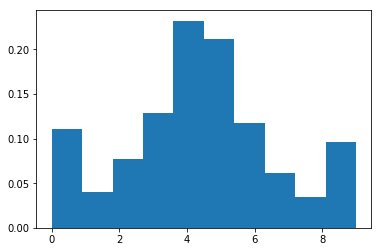

In [188]:
# ---------------------------------------------------------------------------
# area change
# ---------------------------------------------------------------------------
X_da = pd.concat([energy_grad.iloc[:, 1], geo_topo.iloc[:, :5], other.iloc[:, 1:]], axis=1)
da = geo_topo.iloc[:, 5]

print 'extreme area change = ', np.round(float(sum(abs(da) > 500)) / da.shape[0] * 100.0, 2), '%'
bin_edge = np.array([-1e5] + list(np.arange(-500, 501, 100)) + [1e5])
da_bin = pd.cut(da, bin_edge, labels=bin_edge[1:].astype(int))

# plt.hist(da_bin, density=True)


# ---------------------------------------------------------------------------
# face integral mean curvature change
# ---------------------------------------------------------------------------
X_dfms = pd.concat([energy_grad.iloc[:, 1], geo_topo.iloc[:, :5], other.iloc[:, 1:]], axis=1)
dfms = geo_topo.iloc[:, 6]
print 'extreme face integral curvature change = ', np.round(float(sum(abs(dfms) > 200)) / dfms.shape[0] * 100.0, 2), '%'

bin_edge = np.array([-1e5] + list(np.arange(-200, 201, 50)) + [1e5])
# dfms_bin = pd.cut(da, bin_edge, labels=bin_edge[1:].astype(int))
dfms_bin = pd.cut(da, bin_edge, labels=np.arange(bin_edge.shape[0]-1).astype(int))

plt.hist(dfms_bin, density=True)



# Logistic Regression
- Notes
    - only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes
    - only ‘liblinear’ and ‘saga’ handle L1 penalty.
- Parameter importance 
    - np.std(X, 0) * clf.coef_ 
        - https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
- Results
    - L1 & L2
        - Accuracy is similar, but coefs very different
    - 'liblinear' + 'ovr' (one versus all) & 'saga' + 'multinomial'
        - The prediction accuracy is similar.
        - The feature selection effect is much more clear in 'saga' + 'multinomial'.

### Logistic Regression, Vanilla

In [17]:
from sklearn.linear_model import LogisticRegression

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]

# y = mig_sign.mig_n2_sign_ot
# X = energy_grad.iloc[:, 1:]
# mask_onepiece = other.iloc[:,0].astype('bool').values
# X = X[mask_onepiece]

logi_reg = LogisticRegression()

logi_reg.fit(X, y)
print logi_reg.coef_
# print lasso.intercept_
print 'accuracy: ', logi_reg.score(X, y)

/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xiaotingzhong/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[-4.91036916e-04  1.26735980e-02 -1.04689510e-02 -1.89738985e-04
  -8.44767243e-04  2.30483248e-04 -1.70930980e-03  7.06665970e-05
  -1.62567985e-04]
 [-2.98748643e-03  2.15381952e-02 -7.34119017e-03 -1.36963215e-04
   3.22727621e-04 -2.22129260e-05 -1.17936314e-05  2.31211213e-05
  -2.18051397e-05]
 [ 3.63381912e-03 -3.49417326e-02  1.86677593e-02  2.84753754e-04
   5.64532056e-04 -2.24130777e-04  1.76533207e-03 -8.09789336e-05
   1.18224948e-04]]
accuracy:  0.5112792689891491


### Logistic Regression, Lasso

In [61]:
from sklearn.linear_model import LogisticRegression

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]
# X = pd.concat([energy_grad.iloc[:, 1:], geo_topo.iloc[:,:3]], axis=1)
# X = pd.concat([energy_grad.iloc[:, 1:], geo_topo.iloc[:,:5], other.iloc[:, 1:]], axis=1)
# # X = X[['gV_diff_an4', 'fMs_an4']]

# mask = (y != 0)
# X = X[mask]
# y = y[mask]


# y = mig_abs_ot_bin
# # X = X_ot.iloc[:, 9:16]
# X = X_ot


# logi_reg = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=3000, C=0.01)
logi_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=0.01)

# logi_reg.fit(X, y)
# print logi_reg.coef_
# # print lasso.intercept_
# print 'accuracy: ', logi_reg.score(X, y)


# cv_results = cross_validate(logi_reg, X, y, cv=5, return_train_score=True)
# print sorted(cv_results.keys()) 
# print 'test accuracy = ', cv_results['test_score'], cv_results['test_score'].mean()
# print 'training accuracy = ', cv_results['train_score'], cv_results['train_score'].mean()

0.5672178289000719
              precision    recall  f1-score   support

          -1       0.55      0.70      0.62       518
           0       0.00      0.00      0.00       309
           1       0.58      0.75      0.65       564

   micro avg       0.57      0.57      0.57      1391
   macro avg       0.38      0.49      0.42      1391
weighted avg       0.44      0.57      0.50      1391



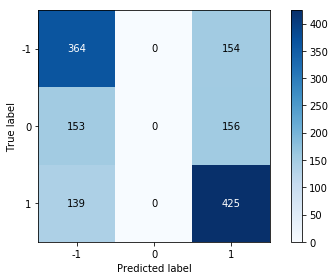

In [62]:
# y = energy_grad.iloc[:, 0]
# X = energy_grad.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logi_reg.fit(X_train, y_train)

X = X_test
y_true = y_test
y_pred = logi_reg.predict(X)

print logi_reg.score(X, y_true)
print classification_report(y_true, y_pred)
plotConfusionMatrix(y_true, y_pred, ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title='logi_reg_mig_sign_conf')

# weighted_coeffs = np.std(X, 0).T*logi_reg.coef_[2,:]
# plotFeatureImportance(weighted_coeffs, X.columns, title='logi_reg_mig_sign_featureImportance')

0.268767377201


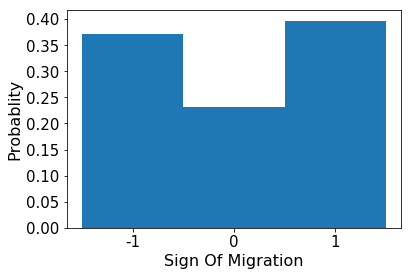

In [63]:
print (151+139.0) / (151+139+366+423.0)
plt.hist(y, bins=[-1, 0, 1, 2], density = True)
plt.xticks([-0.5, 0.5, 1.5], ['-1', '0', '1'], size=15)
plt.yticks(size=15)
plt.ylabel('Probablity',size=16)
plt.xlabel('Sign Of Migration',size=16)
plt.savefig('label distribution', dpi=300, bbox_inches="tight")

### RFE
Feature ranking with recursive feature elimination.

In [38]:
from sklearn.feature_selection import RFE

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]

estimator = LogisticRegression()
selector = RFE(estimator, 3, step=1)
selector = selector.fit(X, y)
print selector.support_ 
print selector.ranking_

[ True  True  True False False False False False False]
[1 1 1 3 2 7 4 6 5]


In [200]:
# tmp = pd.concat([dfms, dfms_bin, X_dfms], axis=1)
# tmp.corr()
geo_topo.corr()

,A_an4,fMs_an4,avg_FabsavgH_an4,C_an4,CnnC_an4,A_diff,fMs_diff,avg_FabsavgH_diff,C_diff,CnnC_diff
A_an4,1.000000,0.662637,-0.092612,0.000831,-0.005495,-0.155289,-0.040644,-0.004101,0.353172,0.347719
fMs_an4,0.662637,1.000000,0.258970,-0.000923,-0.006466,-0.214403,-0.430979,-0.027080,0.246374,0.249933
avg_FabsavgH_an4,-0.092612,0.258970,1.000000,-0.005077,0.000095,0.012280,-0.316204,-0.042516,-0.062154,-0.075413
C_an4,0.000831,-0.000923,-0.005077,1.000000,0.878815,0.000691,0.005141,0.001247,-0.720698,-0.632378
CnnC_an4,-0.005495,-0.006466,0.000095,0.878815,1.000000,0.005679,0.007936,-0.002517,-0.633637,-0.721966
A_diff,-0.155289,-0.214403,0.012280,0.000691,0.005679,1.000000,0.330474,0.000179,0.079570,0.072249
fMs_diff,-0.040644,-0.430979,-0.316204,0.005141,0.007936,0.330474,1.000000,0.038555,0.039237,0.034227
avg_FabsavgH_diff,-0.004101,-0.027080,-0.042516,0.001247,-0.002517,0.000179,0.038555,1.000000,0.000665,0.002052
C_diff,0.353172,0.246374,-0.062154,-0.720698,-0.633637,0.079570,0.039237,0.000665,1.000000,0.876095
CnnC_diff,0.347719,0.249933,-0.075413,-0.632378,-0.721966,0.072249,0.034227,0.002052,0.876095,1.000000


# XGboost
refs:
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [28]:
# y = np.random.randint(3, size=energy_grad.shape[0]) - 1

y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]
# X = pd.concat([energy_grad.iloc[:, 1:], geo_topo.iloc[:,:5], other.iloc[:, 1:]], axis=1)
# # X = X[['gV_diff_an4', 'fMs_an4', 'C_an4']]

# mask_onepiece = other.iloc[:,0].astype('bool').values
# X = geo_topo[mask_onepiece]
# y = mig.iloc[:,0]

# y = mig_sign.mig_n1_sign_ot
# X = energy_grad.iloc[:, 1:]
# mask_onepiece = other.iloc[:,0].astype('bool').values
# X = X[mask_onepiece]

xgb1 = XGBClassifier(
                     learning_rate =0.01,
                     n_estimators=500,
                     max_depth=4,
#                      min_child_weight=1,
                     gamma=0,
                     colsample_bytree=0.6,
                     objective='multi:softmax',
                     scale_pos_weight=1,
                     seed=27
                    )

# ----------- classification -----------
# xgb1.fit(X, y, eval_metric='auc')
cv_results = cross_validate(xgb1, X, y, cv=5, return_train_score=True)
print sorted(cv_results.keys()) 
print cv_results['test_score'], cv_results['test_score'].mean()
print cv_results['train_score'], cv_results['train_score'].mean()
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# # ----------- regression -----------
# # xgb1.fit(X, y)

# # y_pred = xgb1.predict(X)
# # print metrics.accuracy_score(y, y_pred)
# # print xgb1.feature_importances_


['fit_time', 'score_time', 'test_score', 'train_score']
[0.57673091 0.56531049 0.56031406 0.57887223 0.59142857] 0.5745312531864994
[0.64554703 0.65000892 0.64358379 0.63769409 0.63722341] 0.6428114501726986


0.5660242683797287
              precision    recall  f1-score   support

          -1       0.56      0.62      0.59       658
           0       0.00      0.00      0.00        69
           1       0.58      0.57      0.57       674

   micro avg       0.57      0.57      0.57      1401
   macro avg       0.38      0.40      0.39      1401
weighted avg       0.54      0.57      0.55      1401



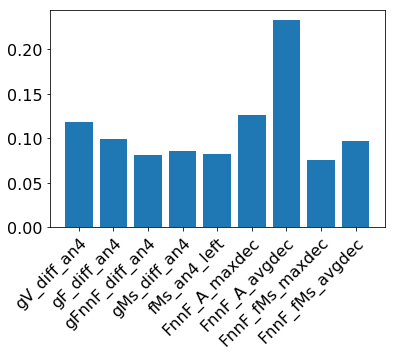

In [29]:
y = energy_grad.iloc[:, 0]
X = energy_grad.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
xgb1.fit(X_train, y_train, eval_metric='auc')

X = X_test
y_true = y_test
y_pred = xgb1.predict(X)


print xgb1.score(X, y_true)
print classification_report(y_true, y_pred)
conf_mat =  confusion_matrix(y_true, y_pred)

# plotConfusionMatrix(y_true, y_pred, ['-1', '0', '1'], normalize=False, rotate_xlabel=False, title='XGBoost_mig_sign_conf')
# plt.show
plotFeatureImportance(xgb1.feature_importances_, X.columns, title='XGBoost_mig_sign_featureImportance')



# Random Forest
refs:
 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# energy_grad = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad.txt')
# X = energy_grad.iloc[:, 1:]
X = pd.concat([energy_grad.iloc[:, 1:], geo_topo.iloc[:,:5], other.iloc[:, 1:]], axis=1)
y = energy_grad.iloc[:, 0]
y_onehot = pd.get_dummies(y)

# energy_grad = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/data/190318_mig_signs.txt')
# X = energy_grad.iloc[:, 2:-1]
# # y = energy_grad.iloc[:, -1]
# y = np.random.randint(3, size=energy_grad.shape[0]) - 1
# y_onehot = pd.get_dummies(y)


rf = RandomForestClassifier(n_estimators = 1000, max_features=5, random_state = 42)
# rf.fit(X, y_onehot);

# y_pred = rf.predict(X)
# print metrics.accuracy_score(y_onehot, y_pred)
# # print rf.score(X, y)
# print rf.feature_importances_


cv_results = cross_validate(rf, X, y_onehot, cv=5, return_train_score=True)
print sorted(cv_results.keys()) 
print cv_results['test_score']
print cv_results['train_score']

['fit_time', 'score_time', 'test_score', 'train_score']
[0.59029265 0.5888651  0.59814418 0.56959315 0.59571429]
[1. 1. 1. 1. 1.]


# CCA 
- To checks:
    - $R_c$ (canonical correlations) and $R_c^2$ (total variance explained by each canonical variate)
    - Helio plot, for correlation between X, Y and each cannonical variate (??? pair ???)(Mandal Fig.9)
        - https://andrewpwheeler.wordpress.com/2013/06/27/some-discussion-on-circular-helio-bar-charts-2/
    - Canonical variate redundancy plot (Mandal Fig.8)
    - Canonical variate pair plots, cv_x vs. cv_y. (Mandal Fig.7)

In [290]:
from sklearn.cross_decomposition import CCA

X = energy_grad
Y = geo_topo


cca = CCA(n_components=10)
cca.fit(X, Y)

U, V = cca.transform(X, Y)
for i in range(10):
    corr = np.corrcoef(U[:,i], V[:,i])[0,1]
    print np.round(corr, 4)

print cca.coef_

0.1134
0.0839
0.0702
0.0601
0.0456
0.0312
0.0268
0.0153
0.0102
0.0017
[[-1.14230620e+02  4.34652501e+00  3.36004720e-01 -2.87462001e+00
  -1.68125547e+00 -1.54075192e+02 -4.08901514e+01  7.90808214e+00
   2.27286098e+00  1.37468668e+00]
 [-1.46783510e+03 -2.55146785e+01  4.84587763e-02  6.07564481e+00
   4.74962866e+00  3.35535104e+01 -1.40393922e+01  1.89849817e+01
  -5.57524458e+00 -5.06167466e+00]
 [-2.57662937e+03 -5.15511482e+01 -2.52342939e-01 -1.07333569e+01
  -5.53053316e+00  4.01192432e+02  8.12371533e+00  4.47600883e+00
   7.47153939e+00  1.81621547e+00]
 [ 4.20756630e+03  1.26470563e+02 -1.13214782e-01  8.03931941e+00
   5.06336136e+00 -6.62454377e+02 -4.41186540e+01 -2.31604852e+01
  -4.45350904e+00 -1.29395329e+00]
 [-1.76386189e+02 -5.90413133e+01  5.52152100e-01  5.86754228e-01
  -4.39589183e-01  5.02325108e+02  6.31160727e+01  5.27138591e+00
  -2.68271412e+00 -1.43792566e+00]
 [ 3.22944503e+02 -9.80065799e+00 -8.07695763e-01 -8.77724648e-01
  -8.60654098e-01  2.00590991

In [48]:
mig = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad.txt')
mig_new = pd.read_csv('/Users/xiaotingzhong/Documents/Matlab/Grain Tracking/190408_features_energygrad_new.txt')

np.sum(mig.iloc[:,0] == mig_new.iloc[:,0])

4522

In [51]:
float(4522) / mig.shape[0]

0.6456310679611651